In [2]:
#Importing
import numpy as np
import matplotlib.pyplot as plt
import os
from matplotlib import colors
import matplotlib.patches as mpatches
import nibabel as nib

In [3]:
#The three functions below use images in the form of numpy arrays to calcualte the scores

def my_dice(img1,img2):
 intersection = np.logical_and(img1, img2) #Finding intersection between the images
 union = np.logical_or(img1, img2) #Finding union between images
 dice = (2*np.sum(intersection))/(np.sum(union)+np.sum(intersection)) #Calculating dice score
 return dice

def sensitivity(pred_image, true_image):
    TP = len(np.where(pred_image + true_image == 2)[0]) #True positives
    FN = len(np.where(pred_image - true_image  == -1)[0]) #False negatives
    TPR = TP/(TP + FN) #Getting the True Postive Rate (Sensitivity)
    return TPR

def specificity(pred_image, true_image):
    TN = len(np.where(pred_image + true_image == 0)[0]) #True negatives
    FP = len(np.where(pred_image - true_image  == 1)[0]) #False positives
    TNR = TN/(TN + FP) #Getting the True Negative Rate (Specificity)
    return TNR

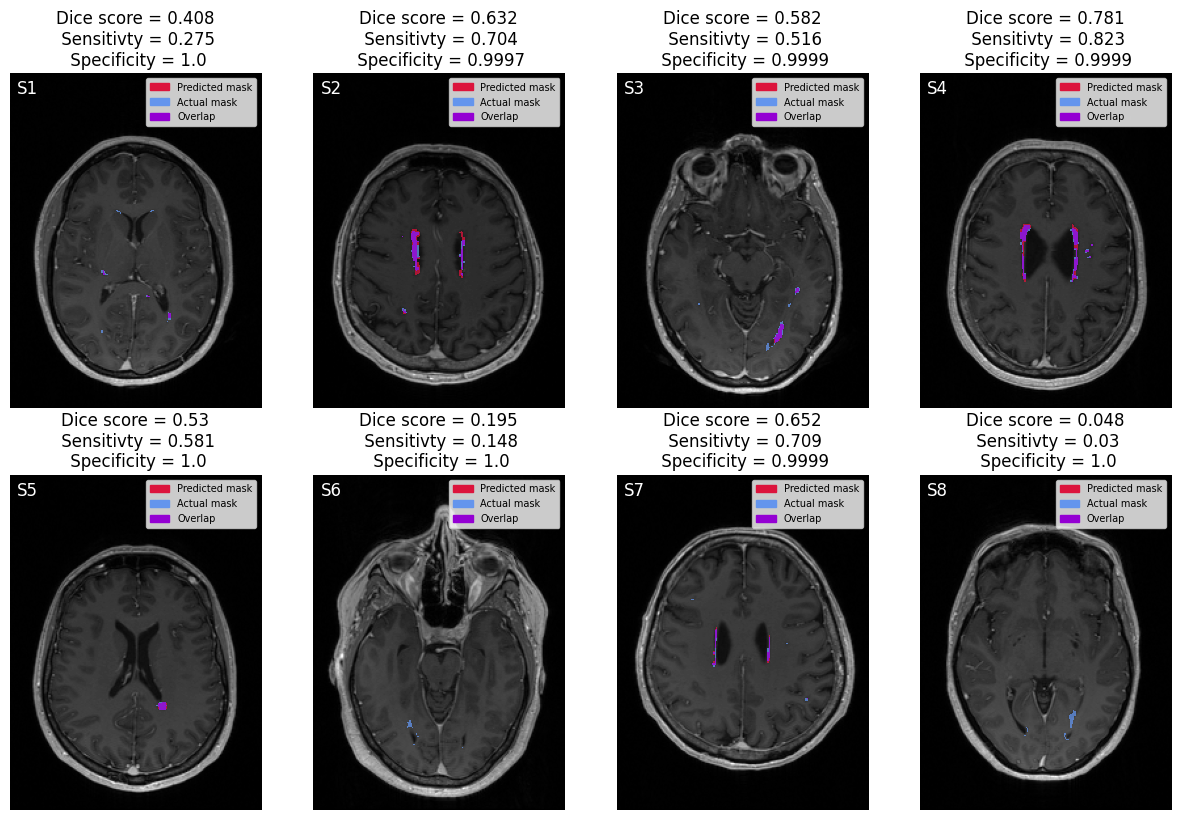

In [5]:
def plot_all(path_to_test_folder):
    all_files_list = []
    for path, dirs, _ in os.walk(path_to_test_folder):
        if len(dirs) == 2: #Set to 2 because the LGA makes two folders
            all_files_list.append(os.path.basename(path))

    #Keep image count to place images correctly
    image_count = 1 

    #Loading in all files and rotating them to point upwards
    for file in all_files_list:
        #Path to T1-wighted, NIfTY image
        scan = np.rot90(nib.load(f'{path_to_test_folder}/{file}/T1.nii').get_fdata()) 

        #Path to true lesion mask, NIfTY image
        mask_true = np.rot90(nib.load(f'{path_to_test_folder}/{file}/lesions_binarised.nii').get_fdata())

        #Path to predicted lesion mask,NIfTY image 
        mask_pred = np.rot90(nib.load(f'{path_to_test_folder}/{file}/lga(0.2)_thr_0.1_map.nii').get_fdata()) 
        

        #Finding the slice that contains the most lesions in the true lesion mask
        best_sum = 0
        for i in range(mask_true.shape[2]):
            binary_mask = mask_true[:,:,i]>0
            if binary_mask.sum() > best_sum:
                best_sum = binary_mask.sum()
                slice_nr = i
            

        #Masking out the regions that do not contain lesions. Otherwise the whole image would be colours
        mask_pred_new = np.ma.masked_where(mask_pred[:,:,slice_nr] == 0, mask_pred[:,:,slice_nr])
        mask_true_new = np.ma.masked_where(mask_true[:,:,slice_nr] == 0, mask_true[:,:,slice_nr])

        #Finding the areas of overlap
        overlap = np.logical_and(mask_pred, mask_true)
        overlap_new = np.ma.masked_where(overlap[:,:,slice_nr] == 0, overlap[:,:,slice_nr])

        #Red is for predicted mask, blue for true mask and purple for the overlap
        cmap = colors.ListedColormap(["crimson"])
        cmap2 = colors.ListedColormap(["cornflowerblue"])
        cmap3 = colors.ListedColormap(["darkviolet"])

        #Creating subplot, presumes that it is eight images to be plotted
        plt.subplot(4, 4, image_count)

        #Plotting T1-image in greysclare
        plt.imshow(scan[:,:,slice_nr], cmap = "gray", alpha = 1.0)
        plt.axis("off")

        #Plotting predicted mask, true mask and overlap
        plt.imshow(mask_pred_new, cmap = cmap, alpha = 0.75)
        plt.imshow(mask_true_new, cmap = cmap2, alpha = 0.75)
        plt.imshow(overlap_new, cmap = cmap3, alpha = 0.80)

        #Adding the performance metrics on top of image
        dice_score = round(my_dice(mask_true, mask_pred), 3)
        sensitivity_score = round(sensitivity(mask_pred, mask_true), 3)
        specificity_score = round(specificity(mask_pred, mask_true), 4)
        title = str ("Dice score = "+ str(dice_score)+ "\n Sensitivty = "\
             + str(sensitivity_score) + "\n Specificity = " + str(specificity_score))

        #Adding title
        plt.title(title)

        #Adding legend explaining the colors
        red_patch = mpatches.Patch(color='crimson', label='Predicted mask')
        blue_patch = mpatches.Patch(color='cornflowerblue', label='Actual mask')
        purple_patch = mpatches.Patch(color='darkviolet', label='Overlap')
        plt.legend(handles = [red_patch, blue_patch, purple_patch], loc = "upper right", prop={'size': 7})

        #Adding subject number and increasing number by 1
        plt.text(5,15, f'S{image_count}', size = 12, color='white')
        image_count += 1

        #Set size of each image in the figure
        plt.gcf().set_size_inches(15, 20)

    #Saving the figure as png and showing it
    plt.savefig('/home/maarhus/Documents/Master/python_code/code/Figures/LGA_seg_all_les.png',\
                     format='png', bbox_inches='tight', dpi =300)
    plt.show()

#The path to the folder containing T1-weighted image, predicted lesion mask and true lesion mask as NIfTI images.
#Using the LGA path as an example
path_test_folder = '/home/maarhus/Documents/Master/Results/Predictions/LGA/MS_DATA_TEST'
plot_all(path_test_folder)